# Spatial Population Structure

Inspired by Tran et al [1], we want to see if our latent space captures spatial components of our populations.

Let's start by using a few of the spatial models simulated in Hao et al's Logistic Factor Analysis paper [2].

<br>
[1] _Tran, D., & Blei, D. M. (2017). Implicit Causal Models for Genome-wide Association Studies. arXiv preprint arXiv:1710.10742._

[2] _Hao, W., Song, M., & Storey, J. D. (2015). Probabilistic models of genetic variation in structured populations applied to global human studies. Bioinformatics, 32(5), 713-721._

## Logistic Factor Analysis (LFA): spatial simulation

We want to recreate the simulated data from Hao et al's 2013 paper. We begin with their simulation genetic data where allele frequencies are shaped by an individuals position on the unit square. The text taken from the supplementary material there.

The LFA model informs our simulation method:
$$
\mathbf{F} = \mathbf{\Gamma S}
$$

is the $m \times n$ matrix of $n$ individuals with measurements at $m$ sites.

Here,  
$$
\mathbf{\Gamma}: m\times d
$$
maps structure to individual allele frequencies, and,   

$$
\mathbf{S}: d\times n \text{ for } d \leq n
$$  
represents sample genetic population structure of latent dimension $d$.  

Each SNPs individual allele frequency are a linear combination of the rows of $\mathbf{S}$ where the weights for SNP i are contained in row i of $\mathbf{\Gamma}$.

We have:
$$
\begin{align}
m & = 100000 \\
n & = 5000 \\
d & =3 \\
\end{align}
$$

where,
$$
\begin{align}
s_{3j} & = 1  \\
s_{ij} & \sim Beta(a, a) \text{ for }  i = 1,2 \text{ and } j \in [1 .. 5000]
\end{align}
$$

Then $\mathbf{\Gamma}$ is constructed by, 
$$
\begin{align}
\gamma_{i3} & = 0.05 \\
\gamma_{ij} & \sim 0.9\times Uniform(0, 0.5) \text{ for } j=1,2
\end{align}
$$


Finally, we construct our genotype matrix by sampling $x_{ij} \sim Binomial(2,  f_{ij})$ with $f_{ij}$ given by equation 1.



In [1]:
import numpy as np

n = 10000 # individuals
m = 1000 # variants
d = 3 # latent dimension

Gamma = np.empty( (m, d) )
Gamma[:, d-1] = 0.05 * np.ones(m)
for j in range(d-1):
    Gamma[:, j] =  0.9 * np.random.uniform(0, 0.5, m)

a = 0.1 # as in the 2015 GCAT paper. Samples are "close" to corners of the unit square
S = np.empty( (d, n) )
S[d-1, :] = np.ones(n)
for i in range(d-1):
    S[i, :] = np.random.beta(a, a, n)

F = Gamma.dot(S)

vsample_genotype = np.vectorize(lambda pi: np.random.binomial(2, pi))
X = vsample_genotype(F).T

np.save('./data/spatial_a-0.1_N-'+ str(n) + '_M-' + str(m) +'.pandas.gz', X)

We can compare plots of the the top two PCA components against plots of the original space defined by $\mathbf{S}$.

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# I'm an adult -- suppress data conversion warning
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X_star = StandardScaler().fit_transform(X)
pca = PCA()
components = pca.fit_transform(X)

<IPython.core.display.Javascript object>


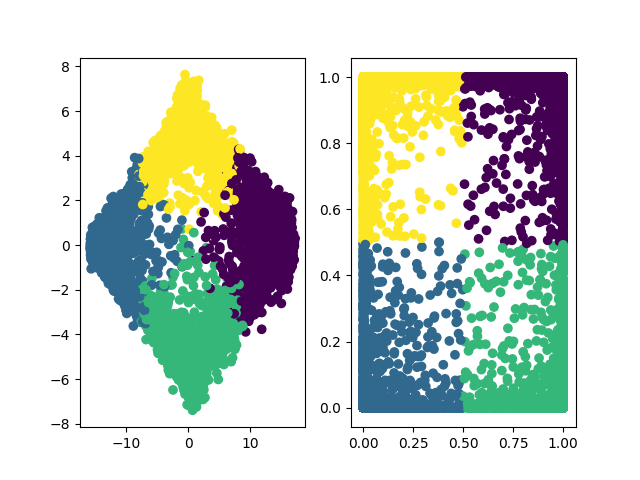

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt
      vimport pandas as pd

# cluster the samples in the original S space to highlight the corners
s_kmeans = cluster.KMeans(n_clusters=4)
s_kmeans.fit(S[0:2, :].T)
y = s_kmeans.labels_
np.save('./data/spatial_a-0.1_N-'+ str(n) + '_M-' + str(m) +'_labels.pandas.gz', y)

df = pd.DataFrame({'PC1': components[:, 0],
                 'PC2': components[:, 1],
                 'S1': S[0, :],
                 'S2': S[1, :],
                 'cluster': s_kmeans.labels_})
df.to_csv('./data/spatial_a-0.1_N-'+ str(n) + '_M-' + str(m) +'.latent_rep.txt', sep='\t')

plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(x=df['PC1'], y=df['PC2'], c = df['cluster'])

plt.subplot(1, 2, 2)
plt.scatter(x=df['S1'], y=df['S2'], c = df['cluster'])

plt.show()


PCA does a good job recovering the latent structure induced by our spatial model.